# Lorenzo La Corte - Progetto Finale

In questo notebook procedo con lo sviluppo di una mia implementazione per la funzione *onset*, che confronto poi con la libreria librosa.

# Implementazione della Onset Detection

Importazione delle librerie:

In [1]:
# librerie principali 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import IPython
from statistics import mean
import warnings
import scipy
warnings.filterwarnings("ignore")
%matplotlib inline

# Install a pip package in the current Jupyter kernel
import sys
# !pip install librosa

# librosa
import librosa
import librosa.display

lib_examples = ["brahms","choice","fishin","humpback","libri1","libri2","libri3","nutcracker","pistachio","robin","sweetwaltz","trumpet","vibeace"]

# Importazione - Visualizzazione - Riproduzione del Suono

Come primo task importiamo un file, in questo caso Lo Schiaccianoci di Čajkovskij, lo carichiamo, lo visualizziamo graficamente e lo riproduciamo.

In [2]:
filename = librosa.example('pistachio')
# filename = librosa.example('humpback')

In [3]:
DURATION = 10
y, sr = librosa.load(filename, duration=DURATION)

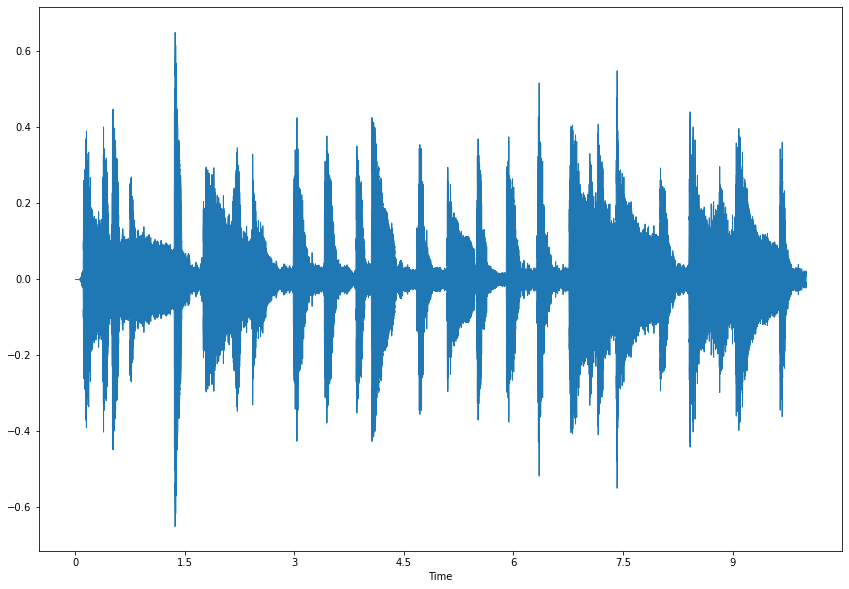

In [4]:
plt.figure(figsize=(14.4,10))
librosa.display.waveshow(y)

In [5]:
IPython.display.Audio(y, rate=sr)

# Onset Detection di Librosa

Utilizzo una strategia che si basa sull'analisi della libreria librosa e sullo studio del problema.

In particolare esploro l'implementazione di librosa scopro che si divide in due funzioni principali:

1. *librosa.onset.onset_strength*: Calcola il *flusso spettrale*, che descrive l'evoluzione dello spettrogramma nel tempo.

2. *librosa.util.utils.peak_pick*: Usa un'euristica flessibile per scegliere i picchi piu' significativi del segnale.

Numero di Onset: 26


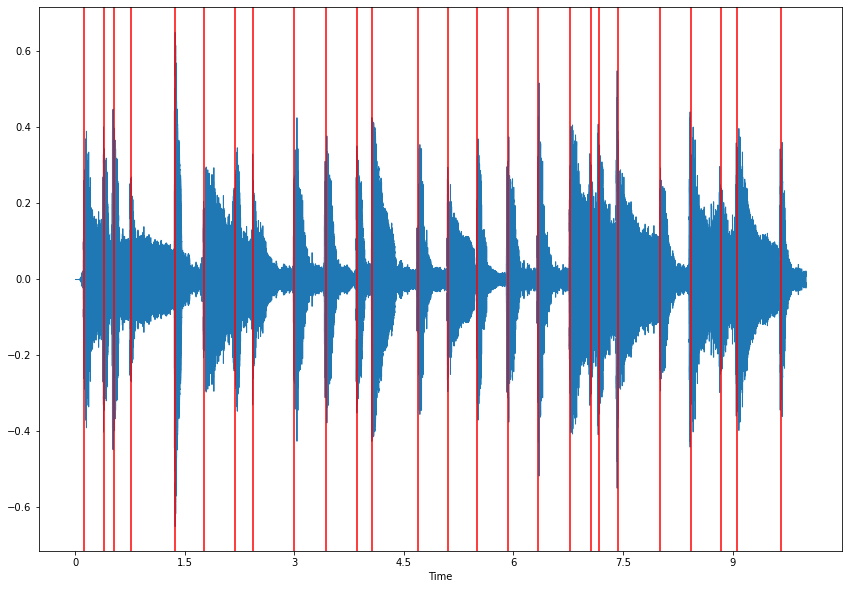

In [6]:
# definisco i parametri principali
n_fft = 1024
hop_length = 512

librosa_onset_frames = librosa.onset.onset_detect(y, sr=sr, hop_length=hop_length)
librosa_onset_times = librosa.onset.onset_detect(y, sr=sr, units='time', hop_length=hop_length)
print("Numero di Onset: " + str(len(librosa_onset_times)))

plt.figure(figsize=(14.4,10))
librosa.display.waveshow(y)
for ot in librosa_onset_times:
    plt.axvline(x=ot, color='r')

# Implementazione Basata sullo Studio del Problema

Nella pubblicazione scientifica *evaluating the online capabilities of onset detection methods* ci vengono illustrati molti metodi per la onset detection, che si dividono principalmente in 3 fasi:

1. Preprocessing: *{filtering, lograrithmic magnitude, adaptive whitening}*
2. Onset Detection Function: *{**spectral flux**, weighted phase deviation, complex domanin}*
3. Peak-Peaking: diviso a sua volta in *preprocessing, thresholding e peak peaking.*

Tutti i moderni algoritmi di onset detection usano una rappresentazione del segnale per frequenze, ottenuta grazie alla STFT.
Anche Librosa fa lo stesso, prima calcolando lo spettrogramma e poi seguendo tecniche analoghe a quelle descritte nell'articolo.

Sappiamo infatti che librosa si basa principalmente sullo **spectral flux**, che risulta essere anche la tecnica piu' moderna ed efficace, per poi andare a implementare il peak-peaking, anch'esso in modo similare a quanto descritto nella pubblicazione.

Provo quindi a costruire la mia onset_detection basandomi su questi macroscopici step; nel dettaglio poi faccio riferimento alle formule dell'articolo, cercando di ottenere un risultato quanto piu' vicino possibile a quello reale. 

In [7]:
def implemented_onset_strength(S, sr, hop_length):
    odf_sf = []
    
    # normalizzazione dello spectral flux
    norm = np.linalg.norm(S.ravel() , ord=2)

    # sommatoria sulle differenze di intensità tra frame vicini  
    for n in range(0,S.shape[1]-1):
        sum = 0
        for k in range(0,S.shape[0]-1):
            sum += abs(S[k,n]) - abs(S[k,n-1])

        odf_sf.append(sum/norm)
    
    # Applico la half-wave rectifier function eliminando i negativi
    odf_sf = np.maximum(0.00, odf_sf)

    return odf_sf

def implemented_peak_pick(odf_sf, w1, w2, w3, w4, delta, w5):
    onsets = []
    n_last_onset = 0 
    
    # scorro tutti i frame di ODF(n)
    for n, odf_value in enumerate(odf_sf):
      
        isPeak = True # se resta True allora è un picco

        # per evitare errori non considero frame che porterebbero a intervalli di tempo negativi
        if (n-w1) < 0 or (n-w3) < 0:
            isPeak = False
            continue
    
       # un odf_value ODF(n) è definito picco se ci sono tre condizioni:
    
        # 1. se ODF(n) = odf_value = max(ODF(n-w1:n+w2))
        if odf_value != max(odf_sf[n-w1:n+w2]):
                isPeak = False

        # 2. se ODF(n) = odf_value >= mean(ODF(n-w3:n+w4)) + delta
        if odf_value < (mean(odf_sf[n-w3:n+w4]) + delta):
                isPeak = False
              
        # 3. se n > (n_last_onset) + w5
        if(n < (n_last_onset + w5)):
            isPeak = False

        if isPeak: 
            onsets.append(n)
            n_last_onset = n
    
    return onsets
        
def my_onset_detect(y, sr):
    
    if y is None:
        raise ParameterError("Assenza di un segnale in input.")
     
    # Parametri per il calcolo dello spettrogramma
    n_mels = 138
    fmin = 27.5
    fmax = 16000.

    global S
    S = librosa.feature.melspectrogram(y, sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax, n_mels=n_mels)
    
    # Onset Detection Function (ODF) basata sullo spectral flux
    global odf_sf
    odf_sf = implemented_onset_strength(S, sr, hop_length)
    
    # Peak-Peaking sullo spectral flux

    # pre_max: 3 valore ottimale secondo l'articolo, librosa gli da 1
    w1 = 3
    
    # post_max: 0-1 valori ottimali secondo l'articolo, librosa gli da 1
    w2 = 1
    
    # pre_avg: valore ottimale tra 4 e 12, librosa gli da 4
    w3 = 4
    
    # post_avg: 0-1 valori ottimali, librosa gli da 1
    w4 = 1
    
    # è la soglia di threshold, librosa gli da 0.07, impostata piu' bassa a causa di una diversa normalizzazione
    delta = 0.003
    
    # wait: 3 valore ottimale, librosa gli da 1
    w5 = 3

    onsets = implemented_peak_pick(odf_sf, w1, w2, w3, w4, delta, w5)
    
    return onsets

Chiamo la funzione implementata e osservo gli onset individuati:

In [17]:
onset_frames = my_onset_detect(y, sr=sr)

print("\nNumero di Onset: " + str(len(onset_frames)))
print("\nOnsets in Frame: ")
print(onset_frames)

onset_times = librosa.core.frames_to_time(onset_frames, sr=sr, hop_length=512, n_fft=1024)
print("\nOnsets in Secondi: ")
print(list(onset_times))


Numero di Onset: 27

Onsets in Frame: 
[4, 16, 22, 28, 32, 57, 75, 93, 104, 128, 146, 165, 174, 201, 219, 236, 254, 272, 291, 302, 307, 318, 344, 361, 379, 389, 415]

Onsets in Secondi: 
[0.11609977324263039, 0.3947392290249433, 0.5340589569160997, 0.6733786848072563, 0.7662585034013606, 1.3467573696145125, 1.7647165532879818, 2.182675736961451, 2.4380952380952383, 2.995374149659864, 3.4133333333333336, 3.8545124716553287, 4.063492063492063, 4.690430839002268, 5.108390022675737, 5.50312925170068, 5.921088435374149, 6.339047619047619, 6.780226757369615, 7.035646258503402, 7.151746031746032, 7.4071655328798185, 8.010884353741497, 8.40562358276644, 8.823582766439909, 9.05578231292517, 9.659501133786849]


## Onset Identificati

Osservo i risultati ottenuti prima sullo spettrogramma e poi sul grafico originale.

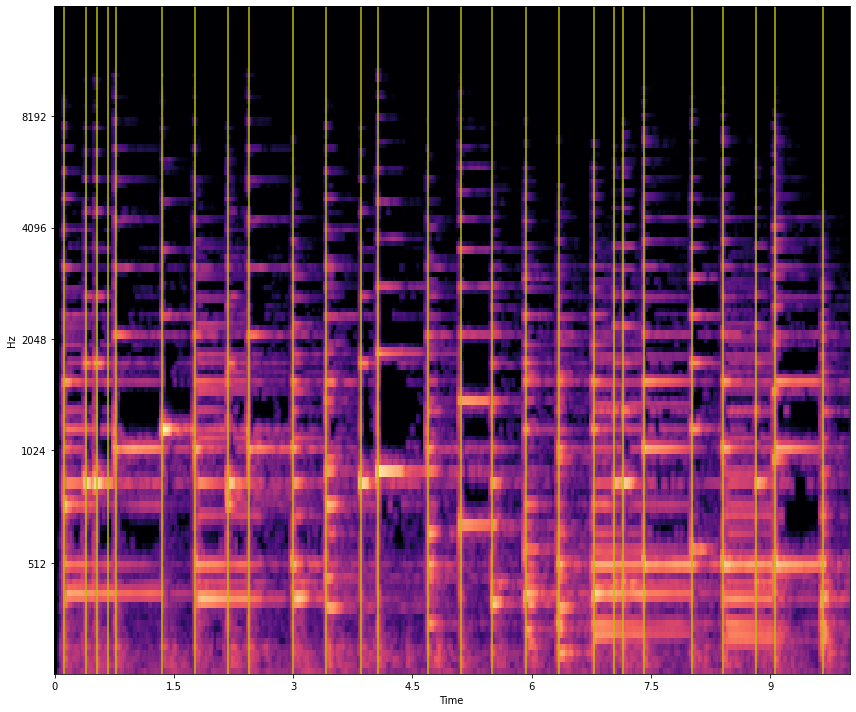

In [9]:
S_to_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,10))
librosa.display.specshow(S_to_db, y_axis='mel', x_axis='time', sr=sr, hop_length=hop_length, fmin=27.5, fmax=16000.)
plt.tight_layout()

for ot in onset_times:
       plt.axvline(x=ot, color='y')

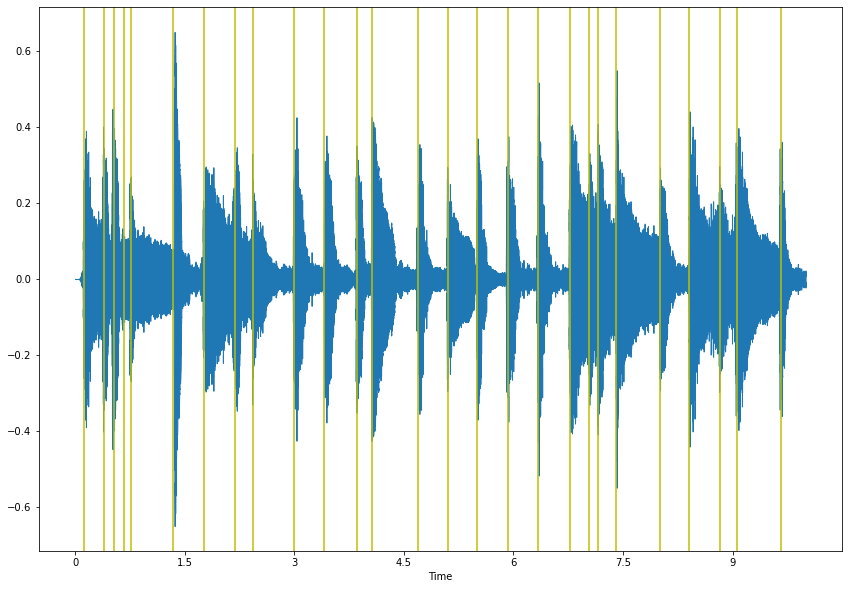

In [10]:
plt.figure(figsize=(14.4,10))
librosa.display.waveshow(y)
for ot in onset_times:
    plt.axvline(x=ot, color='y')

# Confronto tra Librosa e la Mia Implementazione

## Confronto Visivo nel Dettaglio

Osserviamo la curva (azzurra) che deriva dal calcolo dello *spectrul flux* e con essa raffiguriamo:
- in rosso gli onset calcolati da librosa,
- in giallo gli onset calcolati con la nostra implementazione.

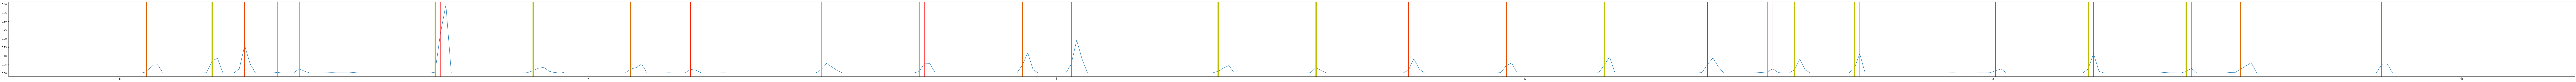

In [11]:
times = librosa.times_like(odf_sf, sr=sr, hop_length=hop_length, n_fft=n_fft)

plt.figure(figsize=(200,6))
plt.plot(times, odf_sf)
                  
for ot in onset_times:
    plt.axvline(x=ot, color='y', lw=5)
    
# lo confronto con gli onset di librosa

for ot in librosa_onset_times:
    plt.axvline(x=ot, color='r')

Ripetiamo lo stesso procedimento solo che visualizziamo la curva dello spectrul flux derivante da librosa.

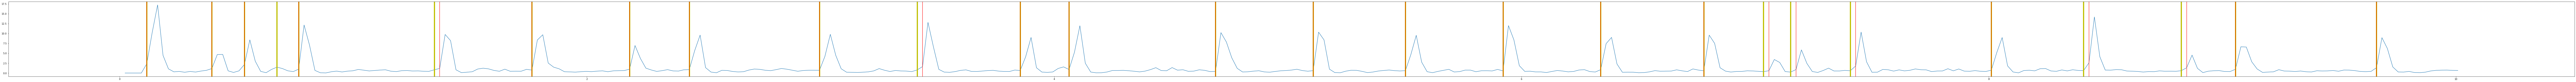

In [12]:
librosa_odf_sf = librosa.onset.onset_strength(y, sr)
librosa_times = librosa.times_like(librosa_odf_sf, sr=sr, hop_length=hop_length, n_fft=n_fft)

plt.figure(figsize=(200,6))
plt.plot(librosa_times, librosa_odf_sf)

# plt.plot(librosa_times[librosa_onset_frames], librosa_odf_sf[librosa_onset_frames], 'o', color='b')

for ot in onset_times:
    plt.axvline(x=ot, color='y', lw=5)
  
# lo confronto con gli onset di librosa

for ot in librosa_onset_times:
    plt.axvline(x=ot, color='r')

## Confronto tra il Numero di Onset

In [13]:
n_lib = len(librosa_onset_frames)
n_imp = len(onset_frames)

print("Numero di Onset di Librosa: \n" + str(n_lib))
print("Numero di Onset dell'Implementazione: \n" + str(n_imp))

print("Differenza in Percentuale: \n" + str(abs((n_lib - n_imp) / max(n_lib, n_imp))*100) + "%")

Numero di Onset di Librosa: 
26
Numero di Onset dell'Implementazione: 
27
Differenza in Percentuale: 
3.7037037037037033%


## Confronto tra Array di Onset

In [14]:
librosa_onset_frames = list(librosa_onset_frames)
print("Librosa: \n" + str(librosa_onset_frames))
print("Implementazione: \n" + str(onset_frames))

Librosa: 
[5, 17, 23, 33, 59, 76, 94, 105, 129, 148, 166, 175, 202, 220, 237, 255, 273, 292, 304, 309, 320, 345, 363, 381, 390, 416]
Implementazione: 
[4, 16, 22, 28, 32, 57, 75, 93, 104, 128, 146, 165, 174, 201, 219, 236, 254, 272, 291, 302, 307, 318, 344, 361, 379, 389, 415]


## Confronto tra le Medie degli Array di Onset

In [15]:
m1 = np.mean(librosa_onset_frames)
m2 = np.mean(onset_frames)
n_frame = librosa.time_to_frames(DURATION, sr=22050, hop_length=hop_length, n_fft=n_fft)

mean_comparison = abs(m1-m2)
print("Confronto tra le Medie degli Array di Onset: " + str(mean_comparison))
print("Pesata sul numero di frame: " + str(mean_comparison/n_frame*100) + "%")

Confronto tra le Medie degli Array di Onset: 7.787749287749278
Pesata sul numero di frame: 1.8153261743005311%


## Confronto della Media della Distanza tra Onset Vicini

In [16]:
def comp_near_frames(l1, l2, how_much_near):  
    imp = 0
    lib = 0
    comp = 0
    acc = 0 

    while(imp < (len(l2)-1) and lib < (len(l1)-1)):
        diff = l1[lib] - l2[imp]
        
        if(abs(diff) < how_much_near):
            acc += abs(diff)
            lib += 1
            imp += 1
            comp += 1

        # se la diff è negativa allora librosa ha un frame molto minore, provo a portare avanti solo il suo indice
        elif(diff < 0):
            lib += 1

        elif(diff > 0):
            imp += 1

    if(comp == 0): return how_much_near
    return (acc/comp)

how_much_near = 10
comparison = comp_near_frames(librosa_onset_frames, onset_frames, how_much_near)
print("Media dei confronti tra onset (in frame) vicini: " + str(comparison))
print("In percentuale con il fattore di vicinanza per la comparazione: " + str(comparison/how_much_near*100) + "%")

Media dei confronti tra onset (in frame) vicini: 1.44
In percentuale con il fattore di vicinanza per la comparazione: 14.399999999999999%
